<a href="https://colab.research.google.com/github/matt-kluska/ml-portfolio/blob/main/DQN_Agent_on_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load up kaggle environment from [gFootball Colab Example](https://github.com/google-research/football)

In [1]:
 !apt-get update
 !apt-get install libsdl2-gfx-dev libsdl2-ttf-dev

# # Make sure that the Branch in git clone and in wget call matches !!
 !git clone -b v2.9 https://github.com/google-research/football.git
 !mkdir -p football/third_party/gfootball_engine/lib

 !wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.8.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
 !cd football && GFOOTBALL_USE_PREBUILT_SO=1 python3 -m pip install .

!pip3 install tf_agents

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,257 kB]
Hit:12 http://ppa.launchpad.net/cra

In [2]:
!pip install kaggle-environments

     |████████████████████████████████| 676 kB 30.1 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 2.6.0
    Uninstalling jsonschema-2.6.0:
      Successfully uninstalled jsonschema-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.5.3 requires jupyter-client>=6.1.5, but you have jupyter-client 5.3.5 which is incompatible.


In [3]:

from kaggle_environments.envs.hungry_geese.hungry_geese import (Observation,
                                                                Configuration,
                                                                Action,
                                                                row_col,
                                                                translate,
                                                                greedy_agent)
from kaggle_environments import evaluate, make, utils

import numpy as np
import random
from tqdm import tqdm
import abc
import tensorflow as tf
import numpy as np
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

tf.compat.v1.enable_v2_behavior()


class TFHungryGoose(py_environment.PyEnvironment):
    def __init__(self):
        env = make("hungry_geese")
        self.trainer = env.train([None, greedy_agent, greedy_agent, greedy_agent])
        obs = self.trainer.reset()
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=3, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(1, 7, 11, 1), dtype=np.float32, minimum=0, maximum=10, name='observation')
        self._state = self.create_grid_from_geese_position(obs)
        self._episode_ended = False
        self.action_name_mapping = {0: 'NORTH', 1: 'SOUTH', 2: 'EAST', 3: 'WEST'}

    def create_grid_from_geese_position(self, obs, grid_cols=11, grid_rows=7):
        geese_position = obs.geese
        foods = obs.food
        my_index = obs.index
        matrix = np.zeros((grid_rows, grid_cols))
        goose_id = [1, 2, 3, 4]
        for i, goose_position in enumerate(geese_position):
            for j, pos in enumerate(goose_position):
                row, col = row_col(pos, grid_cols)
                if j == 0:
                    if i != my_index:
                        matrix[row][col] = 6
                    else:
                        matrix[row][col] = 7
                else:
                    matrix[row][col] = goose_id[i]
        np.put(matrix, foods, [5])
        return matrix.reshape(1, 7, 11, 1).astype('float32')

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        obs = self.trainer.reset()
        self._state = self.create_grid_from_geese_position(obs)
        self._episode_ended = False
        return ts.restart(self._state)

    def __reward_manager(self, reward, step, geese):
      #The reward is calculated as the current turn + goose length.
      return step+ len(geese[0])



      """ old reward version
      if step == 1 and (reward != 0):
          return 50
      elif (reward == 0) or (len(geese[0]) == 0):
          return -400
      elif (max([len(goose) for goose in geese[1:]]) == 0) and (reward != 0):
          return 1000
      elif (reward % 100) == 0:
          return 50
      else:
          return 100"""

    def _step(self, action):
        if self._episode_ended:
            return self.reset()
        action = self.action_name_mapping[int(action)]
        obs, reward, self._episode_ended, info = self.trainer.step(action)
        reward = self.__reward_manager(reward, obs.step, obs.geese)
        self._state = self.create_grid_from_geese_position(obs)
        if self._episode_ended:
            return ts.termination(self._state, reward)
        else:
            return ts.transition(self._state, reward=reward, discount=1.0)
print("Compiled")


Compiled


In [4]:
%load_ext tensorboard


In [6]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.5.0


In [7]:
import tensorboard
tensorboard.__version__

'2.5.0'

In [8]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [9]:
import tensorflow as tf
from tf_agents.networks import sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten,LeakyReLU
from tensorflow.keras.optimizers import Adam
# The QNetwork model
# used leaky relu to address vanishing gradient
model = sequential.Sequential([
    Conv2D(64, kernel_size=3, activation=LeakyReLU()),
    Conv2D(32, kernel_size=3, activation=LeakyReLU()),
    Flatten(),
    Dense(48, activation="relu"),
    Dense(24, activation="relu"),
    Dense(4, activation=None),
])



In [10]:
## test the env on sample episodes
env = TFHungryGoose()
utils.validate_py_environment(env, episodes=5)

In [11]:
!pip install tf_agents

In [12]:
num_iterations = 200000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 25  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 200  # @param {type:"integer"}
eval_interval = 200  # @param {type:"integer"}

In [13]:
from tf_agents.train.utils import strategy_utils, train_utils
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

train_env = tf_py_environment.TFPyEnvironment(TFHungryGoose())
eval_env = tf_py_environment.TFPyEnvironment(TFHungryGoose())

# set the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# step counter
use_gpu = False

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)

# create the DQN agent
with strategy.scope():
  train_step = train_utils.create_train_step()
  train_step_counter = tf.Variable(0)
  agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=model,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

  agent.initialize()

In [14]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(1, 7, 11, 1), dtype=dtype('float32'), name='observation', minimum=0.0, maximum=10.0)


In [15]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [16]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=3)


In [17]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[[0.],
         [0.],
         [0.],
         [5.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [6.]],

        [[6.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [6.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [5.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[7.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],

In [18]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [19]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [20]:
time_step = train_env.reset()

In [21]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([3], dtype=int32)>, state=(), info=())

In [22]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [23]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

21.07

In [24]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [25]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(3, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(1, 7, 11, 1), dtype=tf.float32, name='observation', minimum=array(0., dtype=float32), maximum=array(10., dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [26]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [27]:
#@test {"skip": true}
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env,agent.policy, replay_buffer, initial_collect_steps)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see tutorial 4 or the drivers module.
# https://github.com/tensorflow/agents/blob/master/docs/tutorials/4_drivers_tutorial.ipynb 
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

In [28]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


<PrefetchDataset shapes: (Trajectory(
{action: (64, 2),
 discount: (64, 2),
 next_step_type: (64, 2),
 observation: (64, 2, 1, 7, 11, 1),
 policy_info: (),
 reward: (64, 2),
 step_type: (64, 2)}), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(
{action: tf.int32,
 discount: tf.float32,
 next_step_type: tf.int32,
 observation: tf.float32,
 policy_info: (),
 reward: tf.float32,
 step_type: tf.int32}), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [29]:
iterator = iter(dataset)
print(iterator)

In [30]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):
  #print(_)
  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 7714.0751953125
step = 200: Average Return = 388.69500732421875
step = 400: loss = 7704.34326171875
step = 400: Average Return = 307.1499938964844
step = 600: loss = 1526.8824462890625
step = 600: Average Return = 373.2900085449219
step = 800: loss = 5452.4580078125
step = 800: Average Return = 661.1099853515625
step = 1000: loss = 6370.4033203125
step = 1000: Average Return = 511.8900146484375
step = 1200: loss = 2610.609130859375
step = 1200: Average Return = 502.8599853515625
step = 1400: loss = 5475.4052734375
step = 1400: Average Return = 788.9550170898438
step = 1600: loss = 2859.5849609375
step = 1600: Average Return = 590.0850219726562
step = 1800: loss = 5935.097656

KeyboardInterrupt: ignored

(150.87524337768554, 800.0)

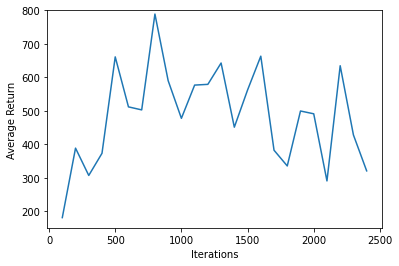

In [49]:
import matplotlib.pyplot as plt


iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(np.linspace(1*10e1,len(returns)*10e1,len(returns)), returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=800)

In [42]:
np.linspace(1,len(returns),len(returns))

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])

In [34]:
len(returns)

24

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [ ]:
import imageio
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    env = make("hungry_geese")
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(env.render())
  return embed_mp4(filename)


In [ ]:
env.render
#create_policy_eval_video(agent.post_process_policy, "random-agent")

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay